# MediaSearch Interleaved A/B Test Analysis

Morten Warncke-Wang, Staff Data Scientist

2020-11-03

## Executive Summary

The Structured Data team ran a A/B test of search on Commons from September 10 to September 17, 2020. During the test, users were shown search results from both the standard search algorithm as well as the new Media Search algorithm at the same time. The Media Search algorithm incorporates structured data (e.g. depicts statements) into the search.

Using data from searches performed during the A/B test, we investigate if users have a preference for the legacy search algorithm or the Media Search algorithm. We find evidence of a strong preference for the Media Search algorithm.

## Introduction

[Structured Data on Commons](https://commons.wikimedia.org/wiki/Commons:Structured_data) has been deployed since January 2019 and enables adding information to media files on Commons in a way that is multilingual and understandable by both humans and machines. As of late September, 2020, [more than half the files on Commons have at least one structured data statement](https://commons.wikimedia.org/w/index.php?title=Commons_talk:Structured_data&oldid=509432565#More_than_half_of_all_files_have_one_or_more_statements).

The Structured Data team in the Wikimedia Foundation has been working on improving the search experience on Commons, both by creating an [improved user experience](https://commons.wikimedia.org/wiki/Special:MediaSearch?type=bitmap), and through collaboration with the Search team creating a search algorithm that incorporates structured data. This A/B test was run in order to understand whether this new search algorithm (hereby referred to as "media search") was preferred by users when compared with the existing search algorithm (from here on referred to as "legacy search").

The A/B test was run over one week in order to account for activity patterns on Wikimedia projects that move in a weekly fashion. It started on September 10 and ended on September 17. The specific timestamps of when it started and ended that are used in the analysis below are extracted from the [Server Admin Log](https://wikitech.wikimedia.org/wiki/Server_Admin_Log).

During the experiment users are shown search results from both the legacy and media search algorithms at the same time through what is called Team-Draft Interleaving. We'll explain how that works below, the key point of using that approach is to get an [unbiased estimator](https://en.wikipedia.org/wiki/Bias_of_an_estimator) of  user preference.

This notebook is based on [Estimating Preference for Ranking Functions with Clicks on Interleaved Search Results](https://people.wikimedia.org/~bearloga/notes/interleaved.html) by WMF Senior Data Scientist Mikhail Popov, and the majority of the code in this notebook is written by him. The work of data quality assurance, sanity checks on the findings (as described below), and writing up this analysis was done by me. For reference, the phabricator task for this analysis is [T261759](https://phabricator.wikimedia.org/T261759).

## Team-Draft Interleaving

As mentioned above, the goal of Team-Draft Interleaving is to get an unbiased estimator of user preference. In other words, we want to know which of the two search algorithms (legacy and media search) that users prefer without introducing some kind of bias in the process.

Per Joachims (2003), the design of a comparison between two search algorithms (in Joachims referred to as "retrieval functions") should:

1. be blind to the user with respect to the underlying conditions.
2. be robust to biases in the user's decision process that do not relate to retrieval quality.
3. not substantially alter the search experience.
4. lead to clicks that reflect the user's preference.

Interleaving the results from two search algorithms addressses these problems, particularly point 3 in that a user cannot tell that they're part of an A/B test nor which algorithm produced the search results they're looking at. 

How does Team-Draft Interleaving work? To borrow an analogy from sports, it's somewhat similar to how teams are selected in a friendly sports match. In that example you might select two team captains, flip a coin to let one of them choose first, and then have them alternate between selecting what they each regard as the top remaining player for their team. They do this until every player is on a team.

Team-Draft Interleaving is the same, except the coin flip happens every time both captains have had an opportunity to make a choice. And instead of team captains and players, we have search algorithms and a ranked list of search results from each of them.

We then use clicks on the search results to understand if a user showed a preference for one of the algorithms over the other. The formula used for calculating the preference statistic can be found in M. Popov's [Estimating Preference for Ranking Functions with Clicks on Interleaved Search Results](https://people.wikimedia.org/~bearloga/notes/interleaved.html) mentioned above. Even more information can be found in Chapelle et al's "Large-scale validation and analysis of interleaved search evaluation" (full reference below).

## Configuration and Data Gathering

In [1]:
# install.packages(c("tidyverse", "remotes", "furrr"))
library(tidyverse)
library(lubridate)
library(future)
plan(multiprocess(workers = getOption("mc.cores", 2)))
library(furrr) # future-enabled purrr

library(wmfdata) # remotes::install_github("wikimedia/wmfdata-r")
library(wmfastr) # remotes::install_github("wikimedia/wmfastr")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [2]:
# Name of the test configuration:
subtest_name = 'mediasearch_commons_int'

# Start and end timestamps (approximate is fine, as we also filter on subtest):
start_ts = ymd_hms('2020-09-10T11:00:00Z')
end_ts = ymd_hms('2020-09-17T12:00:00Z')

The Spark SQL query below gathers all "searchResultPage" (SERP) and "visitPage" events captured during the A/B test. We gather SERP events because they contain information on which algorithm produced a specific search result, while the "visitPage" events capture which search result the user clicked on. The check for `event.subtest` ensures we only capture searches made as part of the A/B test, which in combination with the check for the wiki being Commons (`wiki = 'commonswiki'`) and the time range being within when the test ran makes sure we do not capture unrelated events.

We filter out user agents that are identified as bots (`useragent.is_bot = false`), and we will discuss further sanity checks for automated agents below.

Lastly there are a couple of checks, one to ensure a valid SERP and one to make sure that a "visitPage" event also contains information on what page was clicked. Apart from that the meat of the query grabs all relevant information about the events.

In [3]:
data_query = paste0("USE event;
SELECT
  coalesce(client_dt, meta.dt) AS event_ts,
  event.uniqueId AS event_id,
  event.mwSessionId AS mw_session_id,
  event.pageViewId AS page_id,
  event.articleId AS article_id,
  event.searchSessionId AS session_id,
  event.subTest AS group,
  wiki,
  event.source AS search_type, -- fulltext or autocomplete
  event.searchtoken AS search_token, -- uniquely links visitPage events to specific SRP events
  MD5(LOWER(TRIM(event.query))) AS query_hash,
  event.action AS event,
  IF(event.position < 0, NULL, event.position) AS event_position,
  CASE
    WHEN event.action = 'searchResultPage' AND event.hitsReturned > -1 THEN event.hitsReturned
    WHEN event.action = 'searchResultPage' AND event.hitsReturned IS NULL THEN 0
    ELSE NULL END AS n_results,
  event.extraParams AS event_extraparams
FROM searchsatisfaction
WHERE year = 2020
  AND month = 9
  AND day BETWEEN 10 AND 17
  AND event.subtest = '", subtest_name, "'
  AND coalesce(client_dt, meta.dt) IS NOT NULL
  AND coalesce(client_dt, meta.dt) > '", format_ISO8601(start_ts), "'
  AND coalesce(client_dt, meta.dt) < '", format_ISO8601(end_ts), "'
  AND wiki = 'commonswiki'
  AND event.action IN ('searchResultPage', 'visitPage')
  AND CASE
    WHEN event.action = 'searchResultPage' THEN event.msToDisplayResults IS NOT NULL
    WHEN event.action = 'visitPage' THEN event.pageViewId IS NOT NULL
    ELSE TRUE END
  AND useragent.is_bot = false;"
)

If a backup dataset exists, we use that, otherwise we read data from the Data Lake and back it up to disk.

In [4]:
if (!fs::file_exists("events.rds")) {
    # De-duplicated dataset does not exist yet
    if (fs::file_exists("events_backup.rds")) {
        events <- readr::read_rds("events_backup.rds") # load cached
    } else {
        events = query_hive(data_query)
        readr::write_rds(events, "events_backup.rds", compress = "gz") # cache
    }
    print(c(Events = nrow(events), Sessions = length(unique(events$session_id))))
} else {
    # De-duplicated dataset exists, do nothing
}

NULL

If we have de-duplicated events available on disk we read those in, otherwise we de-duplicate based on the unique identifier each event has, and then write that data to disk.

In [5]:
if (fs::file_exists("events.rds")) {
    events <- readr::read_rds("events.rds") # load cached
} else {
    # De-duplicate events:
    events <- events %>%
      dplyr::mutate(
        timestamp = lubridate::ymd_hms(event_ts),
        date = as.Date(timestamp)
      ) %>%
      dplyr::arrange(session_id, event_id, timestamp) %>%
      dplyr::distinct(session_id, event_id, .keep_all = TRUE)
    readr::write_rds(events, "events.rds", compress = "gz") # cache
}
print(c(Events = nrow(events), Sessions = length(unique(events$session_id))))

  Events Sessions 
  660962    59250 


## Assigning Teams (Search Algorithms) to Clicks

`process_session()` takes an input of events belonging to a session, matches the visited pages with the team drafts in the search result page events, and outputs the memberships. It limits visited pages to those with a position of less than 20, as there is no interleaving on pages beyond the first one, and the highest combined number of interleaved results we have seen is 20.

In [6]:
process_session <- function(events_subset) {
  serp_events <- events_subset %>%
    filter(event == "searchResultPage", event_extraparams != "NULL", n_results > 0) %>%
    # Extract team drafts from the extraParams JSON:
    mutate(team_drafts = map(event_extraparams, ~ jsonlite::fromJSON(.x)$teamDraft)) %>%
    select(page_id, search_token, n_results, team_drafts) %>%
    # Remove SERP events missing team draft info:
    filter(!map_lgl(team_drafts, is.null))
  visit_page_events <- events_subset %>%
    filter(event == "visitPage", event_position < 20) %>%
    select(search_token, article_id)
  visited_teams <- visit_page_events %>%
    left_join(serp_events, by = "search_token") %>%
    mutate(team = map2_chr(article_id, team_drafts, function(id, teams) {
      dplyr::case_when(
        id %in% teams$a ~ "A",
        id %in% teams$b ~ "B",
        TRUE ~ as.character(NA)
      )
    })) %>%
    select(team)
  return(visited_teams)
}

In [7]:
events <- split(events, events$session_id)
visited <- future_map_dfr(events, process_session, .id = "session_id", .progress = FALSE)
write_rds(visited, "visited.rds", compress = "gz")

In [8]:
table(visited$team) # counts of visited pages from the two teams


    A     B 
14251 13591 

## Estimating User Preference

We calculate the user preference statistic and use [bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) to obtain the distribution of said statistic. This allows us to determine 95% confidence interval bounds and thereby determine if there is a statistically significant difference (in which the confidence interval does not cover 0).

If the preference statistic is positive and significant, it indicates a preference for legacy search, while if it is negative and significant, it indicates a preference for media search.

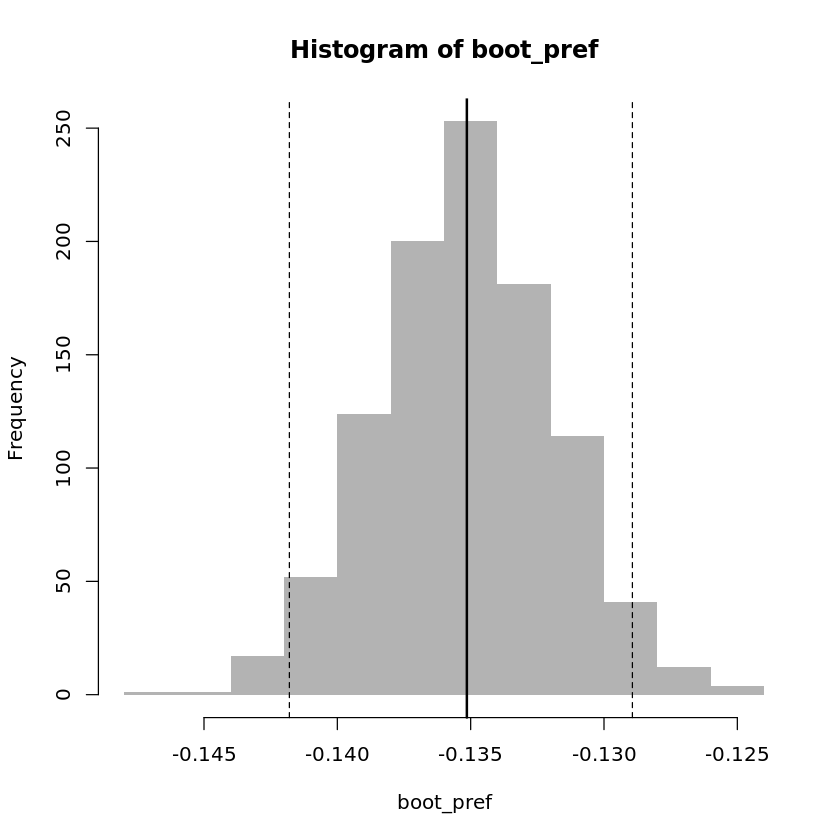

In [9]:
boot_pref <- interleaved_bootstraps(visited$session_id, visited$team)
preference <- interleaved_preference(visited$session_id, visited$team)
hist(boot_pref, col = "gray70", border = NA)
abline(v = quantile(boot_pref, c(0.025, 0.975)), lty = "dashed")
abline(v = preference, lwd = 2)

In [10]:
preference

[1] -0.1351428

In [11]:
quantile(boot_pref, c(0.025, 0.975))

2.5%      97.5% 
-0.1417987 -0.1289354

We find the preference statistics to be negative ($-0.135$) and significant (95% confidence interval $[-0.142, -0.129]$, indicating a preference for the Media Search algorithm.

How strong of a preference for Media Search is this? To get a sense of that, let us start with the definition of the preference statistic as found in [M. Popov's writeup](https://people.wikimedia.org/~bearloga/notes/interleaved.html) and note that it calculates the proportion of wins and gives ties half a point. The subtraction of 0.5 means the statistic is $0$ if it is all ties, $-0.5$ means Media Search won every time, and $0.5$ means legacy search won all the time. If we ignore the ties, then a score of $-0.135$ means legacy search wins 36.5% of the time, or conversely that Media Search wins 63.5% of the time. In other words, our results indicate a *strong preference* for Media Search.

## Sanity Checks

### Sessions with less than 20/50 searches

In previous analysis of search tests run by the Wikimedia Foundation, there has been a threshold on the number of searches per session. This is because a high number of searches suggests a non-human user, and we are interested in understanding the behaviour of humans. We therefore check what the results are if we limit the number of searches per session.

In [12]:
session_lengths <- future_map_int(events, function(x) { nrow(x[x$event == 'searchResultPage', ]) })

In [13]:
session_lengths <- enframe(session_lengths, name = 'session_id', value = 'num_searches')

In [14]:
non_excessive_sessions <- session_lengths %>% filter(num_searches < 20)

In [15]:
non_excessive_visited <- visited %>% filter(session_id %in% non_excessive_sessions$session_id)

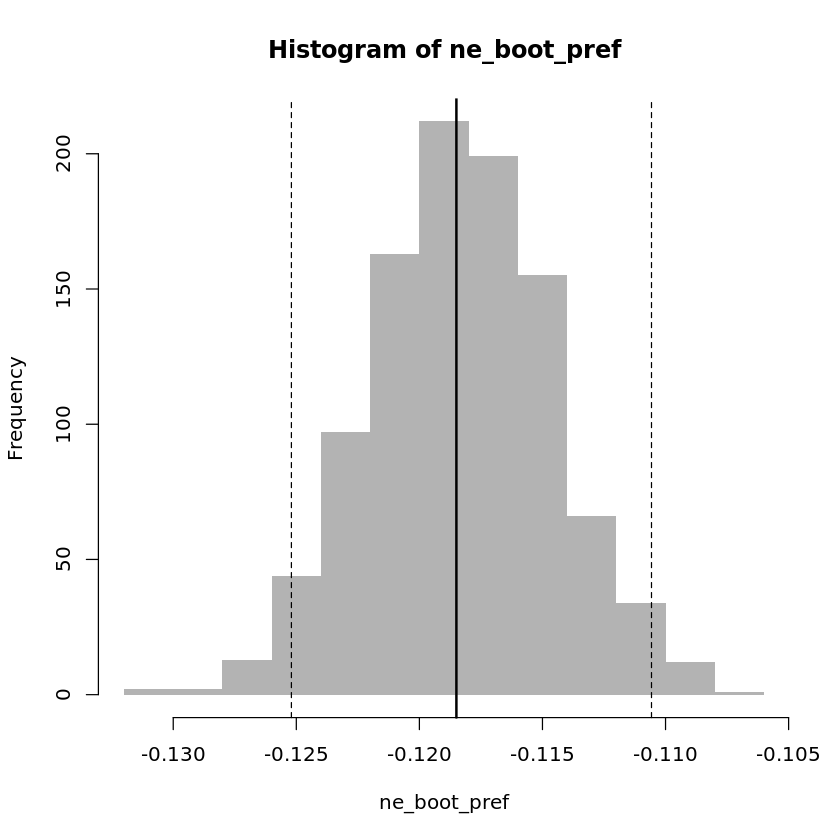

In [16]:
ne_boot_pref <- interleaved_bootstraps(non_excessive_visited$session_id, non_excessive_visited$team)
ne_preference <- interleaved_preference(non_excessive_visited$session_id, non_excessive_visited$team)
hist(ne_boot_pref, col = "gray70", border = NA)
abline(v = quantile(ne_boot_pref, c(0.025, 0.975)), lty = "dashed")
abline(v = ne_preference, lwd = 2)

In [17]:
ne_preference

[1] -0.1184964

In [18]:
quantile(ne_boot_pref, c(0.025, 0.975))

2.5%      97.5% 
-0.1251995 -0.1105705

I have run this with both 50 and 20 searches as the threshold, and the conclusion does not change: it is always a strong preference towards Media Search.

## Conclusion

Our analysis of data from the A/B test on Commons shows a strong preference for the Media Search algorithm over the legacy search algorithm.

## References

* Joachims, T. 2003. Evaluating Retrieval Performance using Clickthrough Data. In Text Mining, J. Franke,
G. Nakhaeizadeh, and I. Renz, Eds., Physica/Springer Verlag, 79–96.
* Chapelle, O., Joachims, T., Radlinski, F., & Yue, Y. (2012). Large-scale validation and analysis of interleaved search evaluation. ACM Transactions on Information Systems, 30(1), 1-41. [doi:10.1145/2094072.2094078](https://doi.org/10.1145/2094072.2094078)
* Radlinski, F. and Craswell, N. (2013). [Optimized interleaving for online retrieval evaluation](https://www.microsoft.com/en-us/research/publication/optimized-interleaving-for-online-retrieval-evaluation/). ACM International Conference on Web Search and Data Mining (WSDM). [doi:10.1145/2433396.2433429](https://doi.org/10.1145/2433396.2433429)